In [194]:
#importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [195]:
#intializing seaborn plots and importing relevant data
sns.set()
status_data = pd.read_csv('E:\EECS\Corona project\COVID_final\patient_data.csv')
country_data = pd.read_csv('E:\EECS\Corona project\COVID_final\covid_19_data.csv')

In [196]:
#cleaning up status_data from binary values (1/0) to boolean (True/False)
status_data = status_data[['id', 'gender', 'age', 'death', 'recovered']]
bools = ['death', 'recovered']
status_data[bools] = status_data[bools].fillna(0)
status_data.loc[(status_data.death.str.len() > 1.0), 'death'] = 1
status_data.loc[(status_data.recovered.str.len() > 1.0), 'recovered'] = 1
status_data[bools] = status_data[bools].astype(int)
status_data[bools] = status_data[bools].astype(bool)

In [197]:
#extracting gender vs. status data and clearing out data with unknown gender
gender = status_data[['gender', 'death', 'recovered']]
gender = gender.dropna(subset=['gender'])
total = len(gender)
male = len(gender[gender['gender'] == 'male'])
female = len(gender[gender['gender'] == 'female'])

#summing patient status count by gender
filtered = gender.groupby('gender').sum()

#changing count to percentage and including new column for percentage of genders in patient data
filtered['positive'] = [male, female]
filtered = filtered / total * 100
filtered = filtered.reset_index()
filtered

,gender,death,recovered,positive
0,female,1.528117,4.889976,55.745721
1,male,3.056235,5.929095,44.254279


In [198]:
#reshaping the gender percentage data for plotting
reshaped = filtered.melt(id_vars=['gender'])
reshaped.columns = ['gender', 'status', 'percentage']
reshaped = reshaped.sort_values(by=['percentage'], ascending=False)

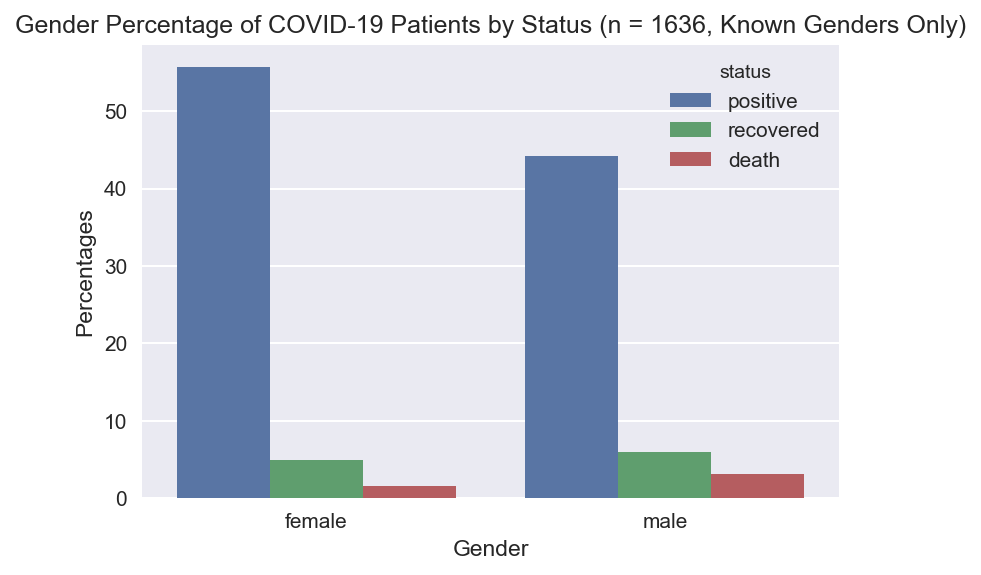

In [199]:
#creating gender bar plot
plt.figure(dpi=150)
gender_plot = sns.barplot(x='gender', y='percentage', data=reshaped, hue='status')
plt.title('Gender Percentage of COVID-19 Patients by Status (n = 1636, Known Genders Only)')
plt.ylabel('Percentages')
plt.xlabel('Gender')
gender_plot

In [200]:
#extracting age vs. status data and clearing out data with unknown age
age = status_data[['age', 'death', 'recovered']]
age = age.dropna(subset=['age'])
total = len(age)

#recatagorizing age from numbers into age groups
age_desc = ['Adolescents(<20)', 'Young Adults (20~39)', 'Adults (40~64)', 'Elderly (65+)']
combined = pd.DataFrame(data={})
adol = age[age.age < 20].copy()
adol.age = age_desc[0]
young = age[(age.age >= 20) & (age.age < 40)].copy()
young.age = age_desc[1]
adults = age[(age.age >= 40) & (age.age < 65)].copy()
adults.age = age_desc[2]
elderly = age[age.age >= 65].copy()
elderly.age = age_desc[3]

#combining dataframes of different age groups, then summing patient status count by age groups
combined = pd.concat([adol, young, adults, elderly])

#changing count to percentage and including new column for percentage of age group in patient data
combined = combined.groupby('age').sum()
combined['confirmed'] = [len(adol), len(adults), len(elderly), len(young)]
combined = combined / total * 100
combined = combined.reindex(age_desc).reset_index()
combined

,age,death,recovered,confirmed
0,Adolescents(<20),0.000000,0.864362,4.255319
1,Young Adults (20~39),0.199468,3.856383,25.132979
2,Adults (40~64),0.997340,5.252660,42.287234
3,Elderly (65+),3.856383,1.130319,28.324468


In [201]:
#reshaping the age percentage data for plotting
reshaped = combined.melt(id_vars=['age'])
reshaped.columns = ['age', 'status', 'percentage']
reshaped

,age,status,percentage
0,Adolescents(<20),death,0.000000
1,Young Adults (20~39),death,0.199468
2,Adults (40~64),death,0.997340
3,Elderly (65+),death,3.856383
4,Adolescents(<20),recovered,0.864362
5,Young Adults (20~39),recovered,3.856383
6,Adults (40~64),recovered,5.252660
7,Elderly (65+),recovered,1.130319
8,Adolescents(<20),confirmed,4.255319
9,Young Adults (20~39),confirmed,25.132979


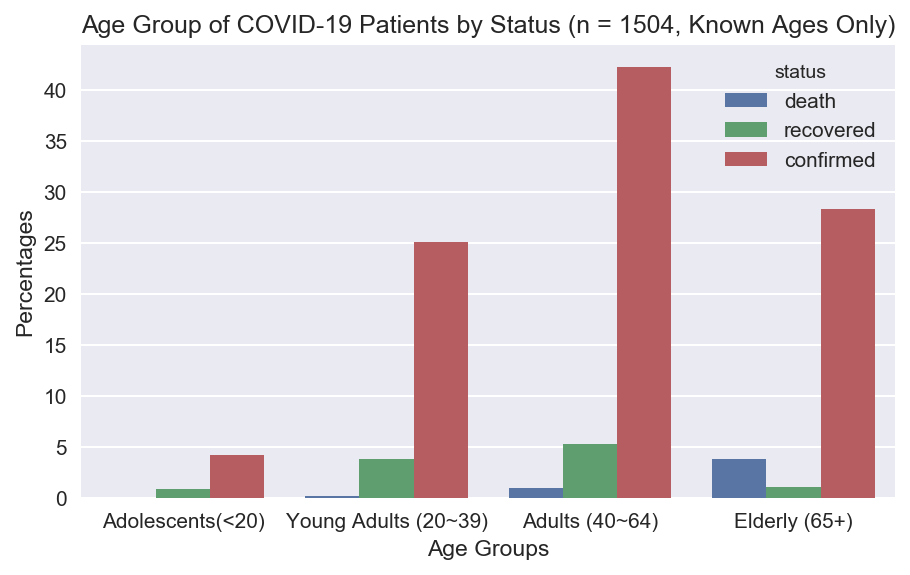

In [202]:
#creating gender bar plot
plt.figure(figsize=(7,4), dpi=150)
age_plot = sns.barplot(x='age', y='percentage', data=reshaped, hue='status')
plt.title('Age Group of COVID-19 Patients by Status (n = 1504, Known Ages Only)')
plt.ylabel('Percentages')
plt.xlabel('Age Groups')
age_plot

In [210]:
#takes in a dataframe and melts the dataframe based on Country/Region, and renaming the columns for formatting
#returns resulting dataframe 
def consolidate(df):
    df = df.melt(id_vars=['Country/Region'])
    df.columns = ['Country/Region', 'Status', 'Count']
    return df

In [211]:
#takes in a dataframe and a note string and creates a bar plot of Country/Region count of patients by status. Title also 
#includes a note stating data as well as range of confirmed patients
def country_plot(df, note):
    plot = sns.barplot(x='Country/Region', y='Count', data=df, hue='Status')
    plt.title('Country/Region Count of Patients by Status (' + note + ')')
    plt.ylabel('Count')
    plt.xlabel('Country/Region')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
    plot

In [212]:
#extracting country vs. status data on two separate dates: 3/7/2020 and 3/14/2020
current = country_data[(country_data['ObservationDate'] == '03/14/2020')]
last_week = country_data[(country_data['ObservationDate'] == '03/07/2020')]
current = current[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
last_week = last_week[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]

#summing both dataframes based on country
current = current.groupby('Country/Region').sum().reset_index()
last_week = last_week.groupby('Country/Region').sum().reset_index()

In [213]:
#creating a dataframe to represent the percent growth rate of the patients in each country from 3/7/2020 to 3/14/2020
#only includes countries/regions that was in the 3/7/2020 dataframe
growth = last_week.loc[:, ['Country/Region']].merge(current, left_on='Country/Region', right_on='Country/Region', how='left')
growth = consolidate(growth)
growth['Count'] = growth['Count'] / consolidate(last_week)['Count']
growth['Count'] = (growth['Count'] - 1) * 100

#for simplicity purposes, setting entries with 0 cases on 3/7/2020 and non-existent entries to 0 growth rate
growth = growth.replace([np.inf, -np.inf], np.nan).fillna(0)

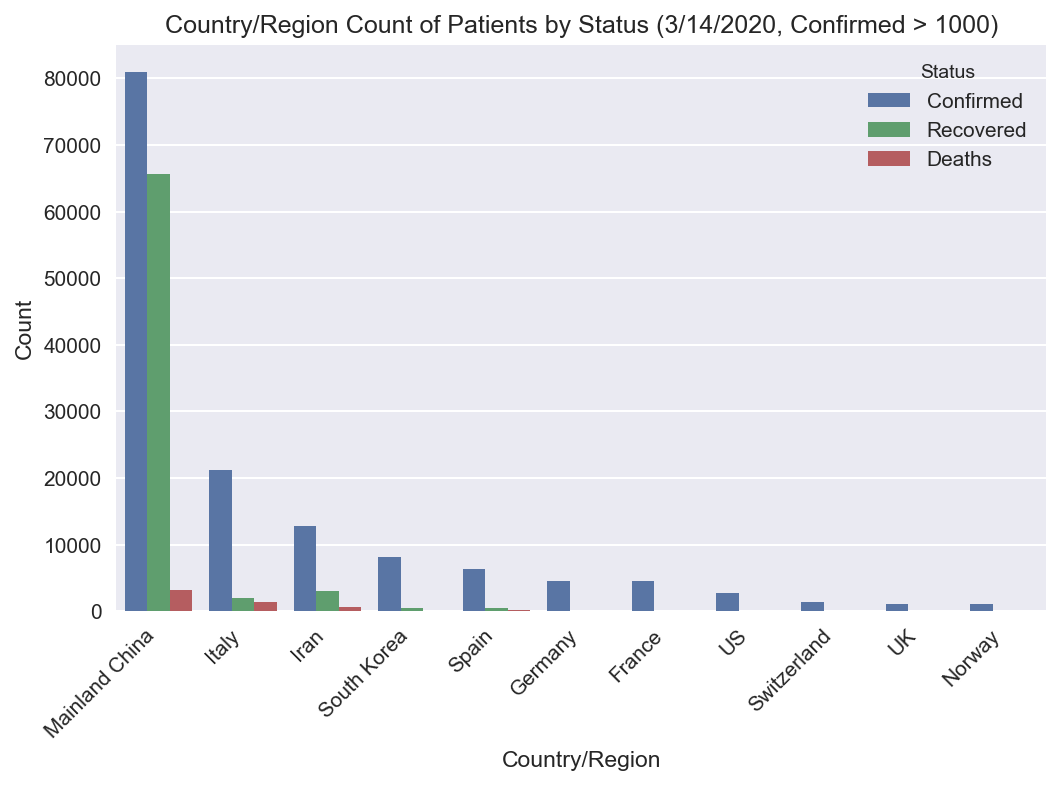

In [214]:
#extracting from the 3/14/2020 dataframe Country/Region entries with more than 1000 confirmed cases and creating a bar plot
more = current[current['Confirmed'] > 1000]
more = consolidate(more)
more = more.sort_values(by=['Count', 'Country/Region'], ascending=False)
plt.figure(figsize=(8,5), dpi=150)
country_plot(more, '3/14/2020, Confirmed > 1000')

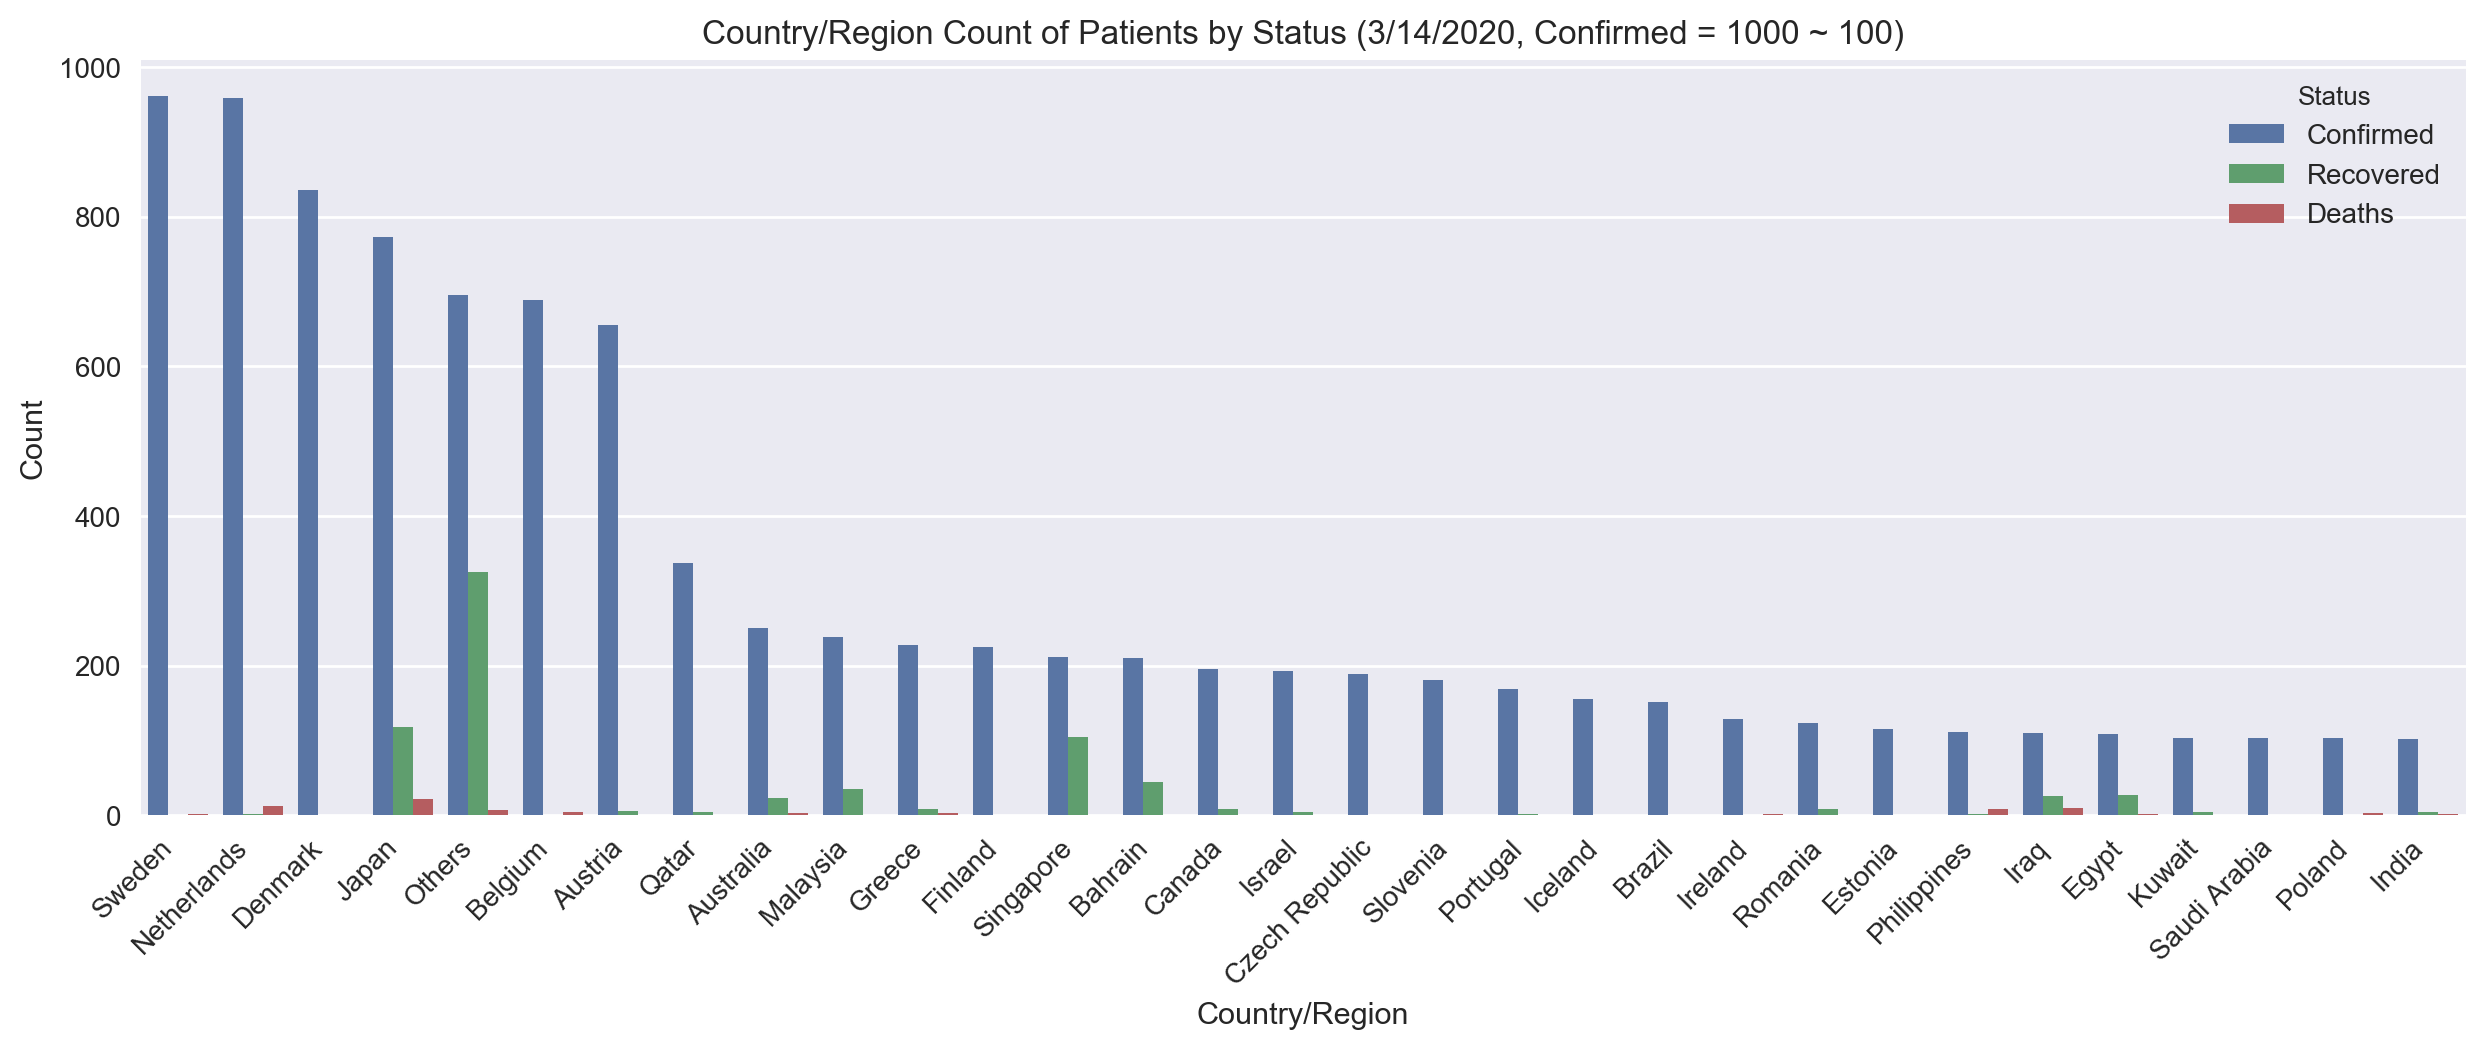

In [222]:
#extracting from the 3/14/2020 dataframe Country/Region entries with between 1000 and 100 confirmed cases and creating 
#a bar plot
less = current[(current['Confirmed'] <= 1000) & (current['Confirmed'] > 100)]
less = consolidate(less)
less = less.sort_values(by=['Count', 'Country/Region'], ascending=False)
plt.figure(figsize=(15,5), dpi=200)
country_plot(less, '3/14/2020, Confirmed = 1000 ~ 100')

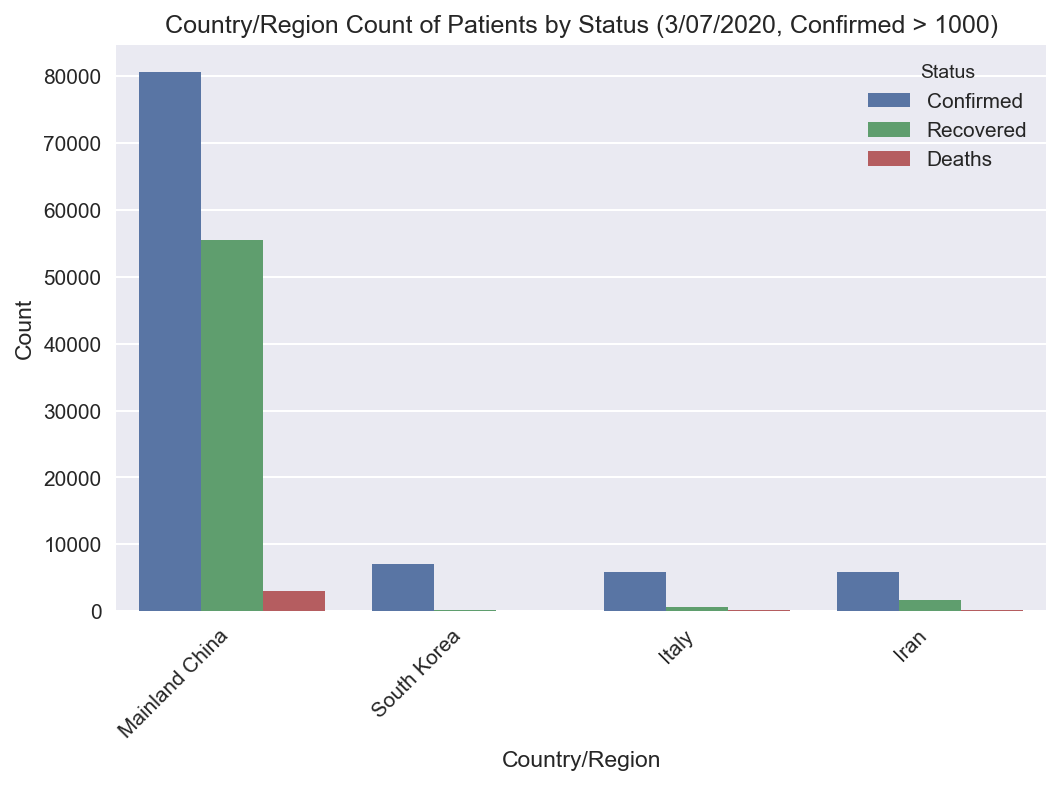

In [216]:
#extracting from the 3/7/2020 dataframe Country/Region entries with more than 1000 confirmed cases and creating a bar plot
more = last_week[last_week['Confirmed'] > 1000]
more = consolidate(more)
more = more.sort_values(by=['Count', 'Country/Region'], ascending=False)
plt.figure(figsize=(8,5), dpi=150)
country_plot(more, '3/07/2020, Confirmed > 1000')

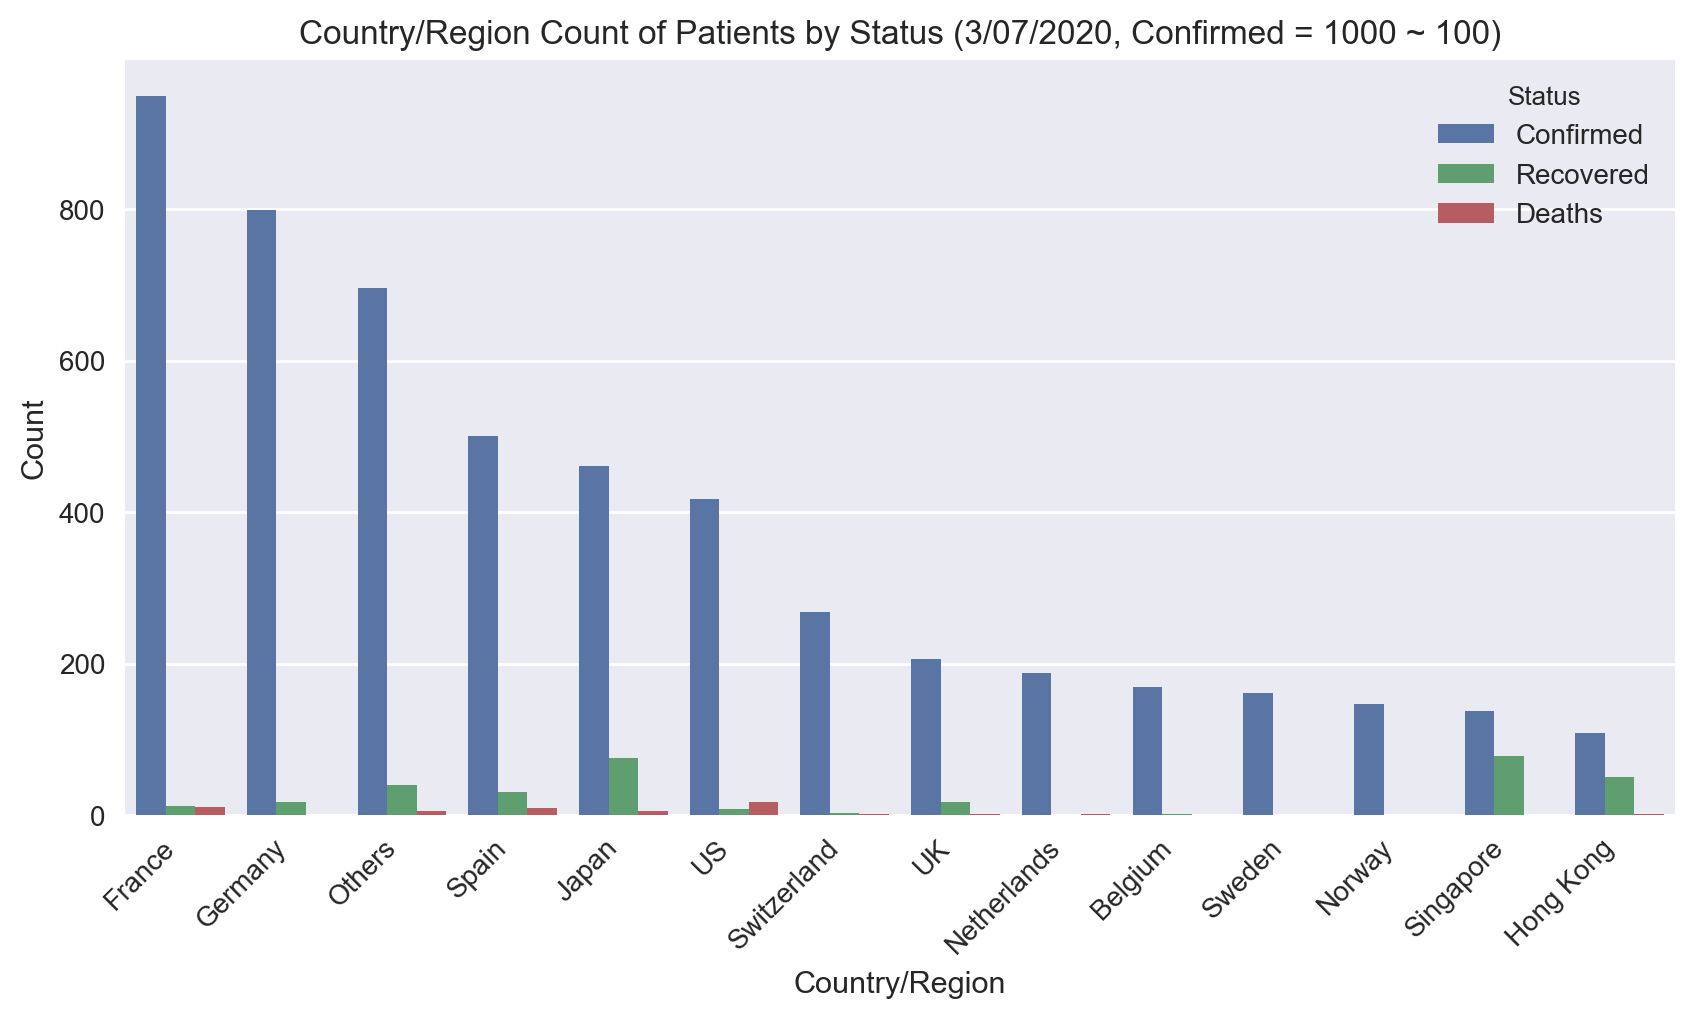

In [221]:
#extracting from the 3/7/2020 dataframe Country/Region entries with between 1000 and 100 confirmed cases and creating 
#a bar plot
less = last_week[(last_week['Confirmed'] <= 1000) & (last_week['Confirmed'] > 100)]
less = consolidate(less)
less = less.sort_values(by=['Count', 'Country/Region'], ascending=False)
plt.figure(figsize=(10,5), dpi=200)
country_plot(less, '3/07/2020, Confirmed = 1000 ~ 100')

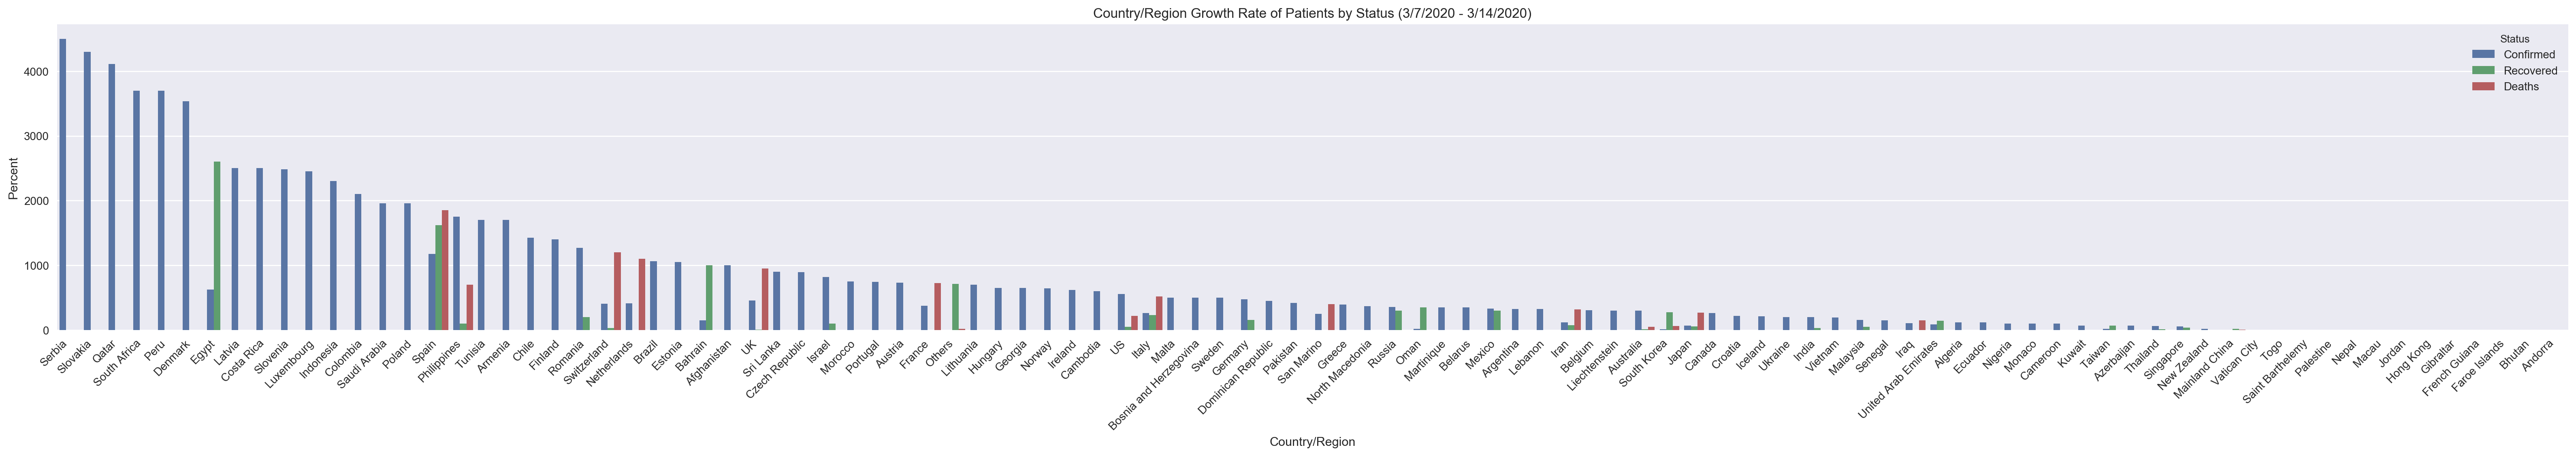

In [193]:
#creating a bar plot for growth rate of patient cases by status between 3/7/2020 and 3/14/2020
growth = growth.sort_values(by=['Count', 'Country/Region'], ascending=False)
plt.figure(figsize=(40,5), dpi=200)
plot = sns.barplot(x='Country/Region', y='Count', data=growth, hue='Status')
plt.title('Country/Region Growth Rate of Patients by Status (3/7/2020 - 3/14/2020)')
plt.ylabel('Percent')
plt.xlabel('Country/Region')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plot